In [1]:
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

import tarfile

# Extract the dataset
dataset_path = "speech_commands_v0.02"
tar_file = "speech_commands_v0.02.tar.gz"
with tarfile.open(tar_file, 'r:gz') as tar:
    tar.extractall(path=dataset_path)


--2024-09-11 04:52:28--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.97.207, 108.177.125.207, 142.250.157.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.97.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  29.5MB/s    in 78s     

2024-09-11 04:53:47 (29.6 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [2]:
import os
import torchaudio
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class SpeechCommandsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.commands = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        self.filepaths = []
        self.labels = []
        self.transform = transform

        for label, command in enumerate(self.commands):
            command_path = os.path.join(data_dir, command)
            wav_files = [os.path.join(command_path, f) for f in os.listdir(command_path) if f.endswith('.wav')]
            self.filepaths.extend(wav_files)
            self.labels.extend([label] * len(wav_files))

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        label = self.labels[idx]
        waveform, sample_rate = torchaudio.load(filepath)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, sample_rate, label

# Load the dataset
data_dir = "speech_commands_v0.02"
dataset = SpeechCommandsDataset(data_dir)


In [3]:
import torch

# Initialize lists for analysis
durations = []
sample_rates = []
command_counts = {command: 0 for command in dataset.commands}

# Analyze the dataset
for waveform, sample_rate, label in dataset:
    durations.append(waveform.shape[1] / sample_rate)
    sample_rates.append(sample_rate)
    command_counts[dataset.commands[label]] += 1

# Convert lists to tensors
durations = torch.tensor(durations)
sample_rates = torch.tensor(sample_rates)

# Print summary statistics
print("Duration Statistics (seconds):\n", torch.mean(durations), torch.std(durations))
print("\nSample Rate Statistics:\n", torch.mean(sample_rates.float()), torch.std(sample_rates.float()))
print("\nCommand Frequency Distribution:\n", command_counts)


Duration Statistics (seconds):
 tensor(0.9846) tensor(0.5082)

Sample Rate Statistics:
 tensor(16000.) tensor(0.)

Command Frequency Distribution:
 {'right': 3778, 'eight': 3787, 'two': 3880, 'on': 3845, 'dog': 2128, 'bed': 2014, 'no': 3941, 'nine': 3934, 'cat': 2031, 'one': 3890, 'up': 3723, 'five': 4052, 'backward': 1664, 'left': 3801, 'learn': 1575, 'marvin': 2100, 'go': 3880, 'follow': 1579, 'tree': 1759, 'off': 3745, 'stop': 3872, 'zero': 4052, 'six': 3860, 'visual': 1592, 'down': 3917, 'forward': 1557, 'happy': 2054, 'house': 2113, 'three': 3727, '_background_noise_': 6, 'sheila': 2022, 'wow': 2123, 'seven': 3998, 'four': 3728, 'yes': 4044, 'bird': 2064}


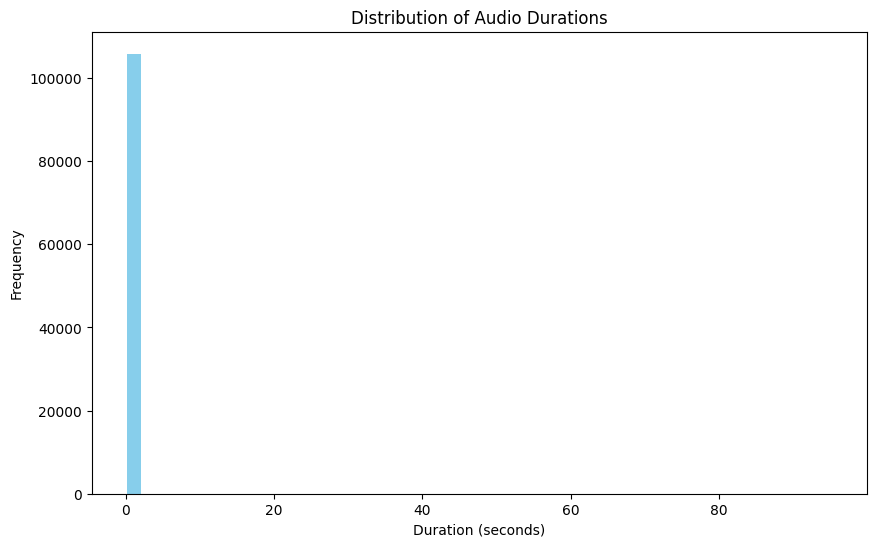

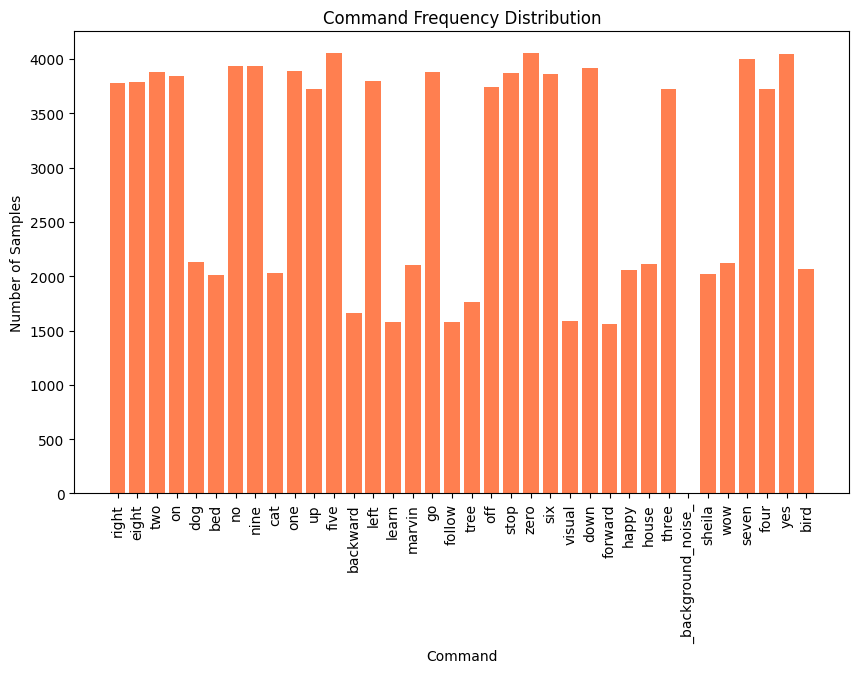

In [4]:
import matplotlib.pyplot as plt

# Histogram of durations
plt.figure(figsize=(10, 6))
plt.hist(durations.numpy(), bins=50, color='skyblue')
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

# Bar plot of command counts
plt.figure(figsize=(10, 6))
plt.bar(command_counts.keys(), command_counts.values(), color='coral')
plt.title("Command Frequency Distribution")
plt.xlabel("Command")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()


In [31]:
import torch
import torchaudio.transforms as T

# Preprocessing to convert waveforms to Mel Spectrograms
class ToMelSpectrogram:
    def __init__(self, n_mels=64, n_fft=1024, hop_length=512):
        self.transform = T.MelSpectrogram(n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)

    def __call__(self, waveform):
        mel_spec = self.transform(waveform)  # [n_mels, time]
        mel_spec = mel_spec.squeeze(0)  # Remove channel dimension if necessary
        return mel_spec  # Should return a 2D tensor [n_mels, time]



In [42]:
import torch.nn as nn
import torch.nn.functional as F
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Adjust the input size of the first fully connected layer
        self.fc1 = nn.Linear(32 * 16 * 8, 128)  # 32 channels * 16 height * 8 width = 4096
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [43]:
import torch.optim as optim
def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)  # Add the channel dimension, shape: [batch_size, 1, n_mels, time]
            optimizer.zero_grad()

            outputs = model(inputs)  # Pass the input to the CNN
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')


In [44]:
dataset = SpeechCommandsDataset(data_dir, transform=ToMelSpectrogram())
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
model = CNNClassifier(num_classes=len(dataset.commands))
train_model(model, train_loader)



Epoch 1, Loss: 2.5821671448242562
Epoch 2, Loss: 1.3898178100261607
Epoch 3, Loss: 1.0407176519031247
Epoch 4, Loss: 0.8554453359919059
Epoch 5, Loss: 0.7273146305210717
Epoch 6, Loss: 0.6363472900338732
Epoch 7, Loss: 0.562955101042031
Epoch 8, Loss: 0.5030891416344382
Epoch 9, Loss: 0.44704664644065617
Epoch 10, Loss: 0.39413859431678033


In [45]:
from sklearn.model_selection import train_test_split

# Assuming your dataset is already loaded
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model and get predictions
all_labels, all_preds = evaluate_model(model, test_loader)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
# Precision, Recall, F1-Score (for multi-class classification, set average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9100
Precision: 0.9116
Recall: 0.9100
F1-Score: 0.9098


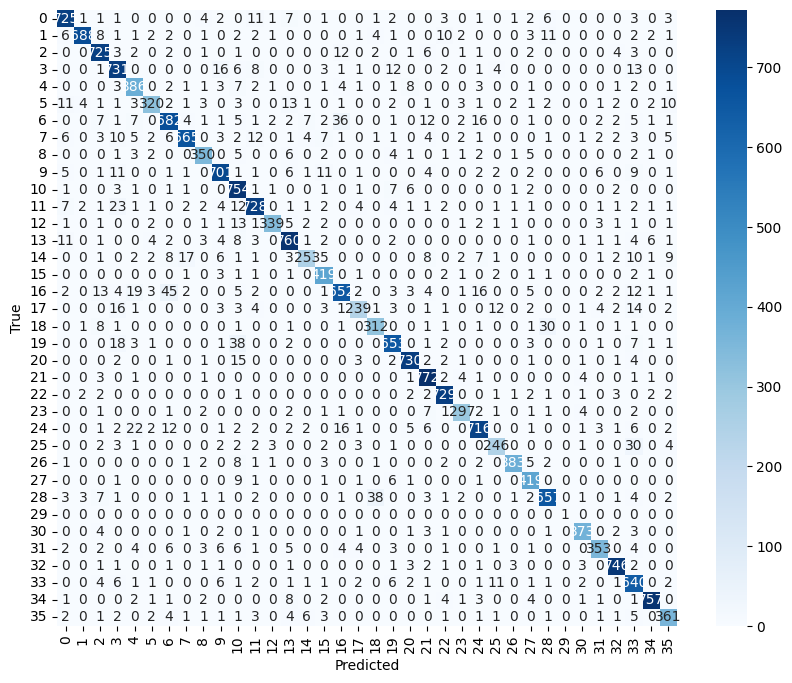

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()